# Initial infrastructure

In [40]:
import pandas as pd
import numpy as np
import os
import re
from dateutil.relativedelta import relativedelta
from statsmodels.tsa import seasonal
from matplotlib import pyplot as plt
from functools import reduce  # Operação de reduce para cálculo de média de uma lista
from datetime import datetime
%matplotlib inline

#Configurações para exibição de tableas
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


# Nomes das colunas adicionadas ao dataframe
COLUNA_ANOMALIA_ACUMULADA = "anomalia_acumulada"
COLUNA_ANOMALIA_DO_MES = "anomalia_mensal"
COLUNA_MEDIA_MENSAL = "media_mensal"

# Todo mês possui 25 linhas por 38 colunas que dá 950
BLOCO_DE_DADOS_DE_UM_MES = 950
QUANTIDADE_DE_VALORES_DO_ARQUIVO = 573800  # (950 blocos x 604 meses,01/1964 até 04/2014)


def constroi_colunas_latitude_longitude(initial_n=29, end_n=0,
                                        initial_s=20, end_s=1,
                                        initial_w=59, end_w=0,
                                        initial_e=16, end_e=1):
    n_values = range(initial_n, end_n, -2)
    s_values = range(end_s, initial_s, 2)
    w_values = range(initial_w, end_w, -2)
    e_values = range(end_e, initial_e, 2)

    colunas = []
    linhas = []

    # LINHAS
    for value in w_values:
        column_name = str(value) + "W"
        linhas.append(column_name)

    for value in e_values:
        column_name = str(value) + "E"
        linhas.append(column_name)

    # COLUNAS
    for value in n_values:
        column_name = str(value) + "N"
        colunas.append(column_name)

    for value in s_values:
        column_name = str(value) + "S"
        colunas.append(column_name)

    colunas_do_data_frame = []
    for linha in linhas:
        for coluna in colunas:
            lat_long = linha + "-" + coluna
            colunas_do_data_frame.append(lat_long)
    return colunas_do_data_frame


def carrega_array_com_valores_do_arquivo_geral(
        arquivo_com_decadas_de_anomalia="funceme_db/anomalia/geral/_Dados_TSMvento_2014_04_anomt6414b04"):
    global QUANTIDADE_DE_VALORES_DO_ARQUIVO

    conteudo_do_arquivo = open(arquivo_com_decadas_de_anomalia).read()
    conteudo_do_arquivo = conteudo_do_arquivo.replace("\n", "")

    # Carrega todos os dados de anomalia em um único array
    qtd_char_no_arquivo = 5
    # Todos os valores do arquivo em um único array. Não há separação de mês. Tudo está de forma sequencial
    valores_do_arquivo = []
    for rows_index in range(QUANTIDADE_DE_VALORES_DO_ARQUIVO):
        # slice data like (n:n+5)
        value = float(conteudo_do_arquivo[
                      rows_index * qtd_char_no_arquivo: rows_index * qtd_char_no_arquivo + qtd_char_no_arquivo])
        value = float("%.3f" % value)
        value /= 10
        valores_do_arquivo.append(value)
    return valores_do_arquivo


def carrega_array_com_valores_do_arquivo_mensal(file_name):
    file_content = open(file_name).read()

    # Remove header de um único arquivo
    file_content = file_content[25:]
    file_content = file_content.replace("\n", "")

    block_size = 5
    dados_do_arquivo = []
    for rows_index in range(BLOCO_DE_DADOS_DE_UM_MES):
        # slice data like (n:n+5)
        value = float(file_content[rows_index * block_size: rows_index * block_size + block_size])
        value = float("%.3f" % value)
        value /= 10
        dados_do_arquivo.append(value)

    return dados_do_arquivo


def merge_dados_do_diretorio(diretorio_anomalia_individual="funceme_db/anomalia/individual/"):
    global QUANTIDADE_DE_VALORES_DO_ARQUIVO
    lista_de_arquivos_individuais = []
    arquivos_do_diretorio = os.listdir(diretorio_anomalia_individual)

    quantidade_de_arquivos = 0
    # Adiciona apenas arquivos com extensão .22
    for arquivo in arquivos_do_diretorio:
        if arquivo.endswith(".22"):
            lista_de_arquivos_individuais.append(arquivo)
            quantidade_de_arquivos += 1

    valores_dos_arquivos = carrega_array_com_valores_do_arquivo_geral()
    # Para cada arquivo na lista é feito append na lista full_data
    for arquivo in lista_de_arquivos_individuais:
        dados_mensais = carrega_array_com_valores_do_arquivo_mensal(diretorio_anomalia_individual + arquivo)
        for item in dados_mensais:
            valores_dos_arquivos.append(item)

    ##44 meses de 05/2014 até 12/2017
    QUANTIDADE_DE_VALORES_DO_ARQUIVO += quantidade_de_arquivos * BLOCO_DE_DADOS_DE_UM_MES  # Que dá 41800

    array_de_anomalias_por_mes = []
    for i in range(0, QUANTIDADE_DE_VALORES_DO_ARQUIVO, 950):
        anomalias_do_mes = valores_dos_arquivos[i:i + BLOCO_DE_DADOS_DE_UM_MES]
        array_de_anomalias_por_mes.append(anomalias_do_mes)
    return array_de_anomalias_por_mes


def inicia_funceme_data_frame():
    funceme_df = pd.DataFrame()
    for anomalias_do_mes in array_de_anomalias_por_mes:
        data = np.array(anomalias_do_mes)
        row_df = pd.DataFrame(data.reshape(-1, len(data)), columns=constroi_colunas_latitude_longitude())
        funceme_df = funceme_df.append(row_df)
    funceme_df.index = range(0, len(array_de_anomalias_por_mes), 1)
    # ### Setando indices baseados na data
    FORMAT = "%Y-%m"
    some_date_time1 = "1964-01"
    data_inicial = datetime.strptime(some_date_time1, FORMAT)
    indexes_data = []
    for i in range(len(array_de_anomalias_por_mes)):
        indexes_data.append(data_inicial + relativedelta(months=i))
    funceme_df = funceme_df.set_index(pd.DatetimeIndex(data=indexes_data))
    
    return funceme_df

def plota_coluna_do_dataframe(dataframe,titulo, nome_da_coluna):
    fig, axarr = plt.subplots(1)
    fig.set_size_inches(8, 5)
    ax=dataframe[nome_da_coluna].plot( color='b', linestyle='-', grid=True)
    ax.set(xlabel="Year", ylabel="Celsius/10")

    plt.title(titulo)
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)
    plt.axhline(0, color='black')
#     plt.axvline(0, color='red')
    plt.show()


height has been deprecated.



# Loading FUNCEME data

In [41]:

array_de_anomalias_por_mes = merge_dados_do_diretorio()
geral_df = inicia_funceme_data_frame()


In [42]:
geral_df.head(5)

,59W-29N,59W-27N,59W-25N,59W-23N,59W-21N,59W-19N,59W-17N,59W-15N,59W-13N,59W-11N,59W-9N,59W-7N,59W-5N,59W-3N,59W-1N,59W-1S,59W-3S,59W-5S,59W-7S,59W-9S,59W-11S,59W-13S,59W-15S,59W-17S,59W-19S,57W-29N,57W-27N,57W-25N,57W-23N,57W-21N,57W-19N,57W-17N,57W-15N,57W-13N,57W-11N,57W-9N,57W-7N,57W-5N,57W-3N,57W-1N,57W-1S,57W-3S,57W-5S,57W-7S,57W-9S,57W-11S,57W-13S,57W-15S,57W-17S,57W-19S,55W-29N,55W-27N,55W-25N,55W-23N,55W-21N,55W-19N,55W-17N,55W-15N,55W-13N,55W-11N,55W-9N,55W-7N,55W-5N,55W-3N,55W-1N,55W-1S,55W-3S,55W-5S,55W-7S,55W-9S,55W-11S,55W-13S,55W-15S,55W-17S,55W-19S,53W-29N,53W-27N,53W-25N,53W-23N,53W-21N,53W-19N,53W-17N,53W-15N,53W-13N,53W-11N,53W-9N,53W-7N,53W-5N,53W-3N,53W-1N,53W-1S,53W-3S,53W-5S,53W-7S,53W-9S,53W-11S,53W-13S,53W-15S,53W-17S,53W-19S,51W-29N,51W-27N,51W-25N,51W-23N,51W-21N,51W-19N,51W-17N,51W-15N,51W-13N,51W-11N,51W-9N,51W-7N,51W-5N,51W-3N,51W-1N,51W-1S,51W-3S,51W-5S,51W-7S,51W-9S,51W-11S,51W-13S,51W-15S,51W-17S,51W-19S,49W-29N,49W-27N,49W-25N,49W-23N,49W-21N,49W-19N,49W-17N,49W-15N,49W-13N,49W-11N,49W-9N,49W-7N,49W-5N,49W-3N,49W-1N,49W-1S,49W-3S,49W-5S,49W-7S,49W-9S,49W-11S,49W-13S,49W-15S,49W-17S,49W-19S,47W-29N,47W-27N,47W-25N,47W-23N,47W-21N,47W-19N,47W-17N,47W-15N,47W-13N,47W-11N,47W-9N,47W-7N,47W-5N,47W-3N,47W-1N,47W-1S,47W-3S,47W-5S,47W-7S,47W-9S,47W-11S,47W-13S,47W-15S,47W-17S,47W-19S,45W-29N,45W-27N,45W-25N,45W-23N,45W-21N,45W-19N,45W-17N,45W-15N,45W-13N,45W-11N,45W-9N,45W-7N,45W-5N,45W-3N,45W-1N,45W-1S,45W-3S,45W-5S,45W-7S,45W-9S,45W-11S,45W-13S,45W-15S,45W-17S,45W-19S,43W-29N,43W-27N,43W-25N,43W-23N,43W-21N,43W-19N,43W-17N,43W-15N,43W-13N,43W-11N,43W-9N,43W-7N,43W-5N,43W-3N,43W-1N,43W-1S,43W-3S,43W-5S,43W-7S,43W-9S,43W-11S,43W-13S,43W-15S,43W-17S,43W-19S,41W-29N,41W-27N,41W-25N,41W-23N,41W-21N,41W-19N,41W-17N,41W-15N,41W-13N,41W-11N,41W-9N,41W-7N,41W-5N,41W-3N,41W-1N,41W-1S,41W-3S,41W-5S,41W-7S,41W-9S,41W-11S,41W-13S,41W-15S,41W-17S,41W-19S,...,3W-29N,3W-27N,3W-25N,3W-23N,3W-21N,3W-19N,3W-17N,3W-15N,3W-13N,3W-11N,3W-9N,3W-7N,3W-5N,3W-3N,3W-1N,3W-1S,3W-3S,3W-5S,3W-7S,3W-9S,3W-11S,3W-13S,3W-15S,3W-17S,3W-19S,1W-29N,1W-27N,1W-25N,1W-23N,1W-21N,1W-19N,1W-17N,1W-15N,1W-13N,1W-11N,1W-9N,1W-7N,1W-5N,1W-3N,1W-1N,1W-1S,1W-3S,1W-5S,1W-7S,1W-9S,1W-11S,1W-13S,1W-15S,1W-17S,1W-19S,1E-29N,1E-27N,1E-25N,1E-23N,1E-21N,1E-19N,1E-17N,1E-15N,1E-13N,1E-11N,1E-9N,1E-7N,1E-5N,1E-3N,1E-1N,1E-1S,1E-3S,1E-5S,1E-7S,1E-9S,1E-11S,1E-13S,1E-15S,1E-17S,1E-19S,3E-29N,3E-27N,3E-25N,3E-23N,3E-21N,3E-19N,3E-17N,3E-15N,3E-13N,3E-11N,3E-9N,3E-7N,3E-5N,3E-3N,3E-1N,3E-1S,3E-3S,3E-5S,3E-7S,3E-9S,3E-11S,3E-13S,3E-15S,3E-17S,3E-19S,5E-29N,5E-27N,5E-25N,5E-23N,5E-21N,5E-19N,5E-17N,5E-15N,5E-13N,5E-11N,5E-9N,5E-7N,5E-5N,5E-3N,5E-1N,5E-1S,5E-3S,5E-5S,5E-7S,5E-9S,5E-11S,5E-13S,5E-15S,5E-17S,5E-19S,7E-29N,7E-27N,7E-25N,7E-23N,7E-21N,7E-19N,7E-17N,7E-15N,7E-13N,7E-11N,7E-9N,7E-7N,7E-5N,7E-3N,7E-1N,7E-1S,7E-3S,7E-5S,7E-7S,7E-9S,7E-11S,7E-13S,7E-15S,7E-17S,7E-19S,9E-29N,9E-27N,9E-25N,9E-23N,9E-21N,9E-19N,9E-17N,9E-15N,9E-13N,9E-11N,9E-9N,9E-7N,9E-5N,9E-3N,9E-1N,9E-1S,9E-3S,9E-5S,9E-7S,9E-9S,9E-11S,9E-13S,9E-15S,9E-17S,9E-19S,11E-29N,11E-27N,11E-25N,11E-23N,11E-21N,11E-19N,11E-17N,11E-15N,11E-13N,11E-11N,11E-9N,11E-7N,11E-5N,11E-3N,11E-1N,11E-1S,11E-3S,11E-5S,11E-7S,11E-9S,11E-11S,11E-13S,11E-15S,11E-17S,11E-19S,13E-29N,13E-27N,13E-25N,13E-23N,13E-21N,13E-19N,13E-17N,13E-15N,13E-13N,13E-11N,13E-9N,13E-7N,13E-5N,13E-3N,13E-1N,13E-1S,13E-3S,13E-5S,13E-7S,13E-9S,13E-11S,13E-13S,13E-15S,13E-17S,13E-19S,15E-29N,15E-27N,15E-25N,15E-23N,15E-21N,15E-19N,15E-17N,15E-15N,15E-13N,15E-11N,15E-9N,15E-7N,15E-5N,15E-3N,15E-1N,15E-1S,15E-3S,15E-5S,15E-7S,15E-9S,15E-11S,15E-13S,15E-15S,15E-17S,15E-19S
1964-01-01,0.4,0.4,0.5,0.5,0.5,0.5,0.4,0.2,0.0,0.0,0.1,0.1,0.6,0.0,0.0,0.0,-0.1,-0.1,-0.3,-0.2,0.0,0.2,0.3,0.2,9999.8,9999.8,9999.8,9999.8,9999.8,9999.8,9999.8,9999.8,9999.8,9999.8,9999.8,9999.8,9999.8,9999.8,0.3,0.5,0.5,0.6,0.5,0.4,0.4,0.1,0.0,0.0,0.0,0.2,0.1,0.1,0.1,0.3,0.2,0.1,-0.1,-0.1,0.2,0.4,0.4,9999.8,9999.8,9999.8,9999.8,9999.8,9999.8,9999.8,9999.8,9999.8,9999

## Filter data jan/2003 - dez/2017

In [43]:
funceme_df = geral_df.loc['2003-01-01':'2017-12-01']
funceme_df.head(5)


,59W-29N,59W-27N,59W-25N,59W-23N,59W-21N,59W-19N,59W-17N,59W-15N,59W-13N,59W-11N,59W-9N,59W-7N,59W-5N,59W-3N,59W-1N,59W-1S,59W-3S,59W-5S,59W-7S,59W-9S,59W-11S,59W-13S,59W-15S,59W-17S,59W-19S,57W-29N,57W-27N,57W-25N,57W-23N,57W-21N,57W-19N,57W-17N,57W-15N,57W-13N,57W-11N,57W-9N,57W-7N,57W-5N,57W-3N,57W-1N,57W-1S,57W-3S,57W-5S,57W-7S,57W-9S,57W-11S,57W-13S,57W-15S,57W-17S,57W-19S,55W-29N,55W-27N,55W-25N,55W-23N,55W-21N,55W-19N,55W-17N,55W-15N,55W-13N,55W-11N,55W-9N,55W-7N,55W-5N,55W-3N,55W-1N,55W-1S,55W-3S,55W-5S,55W-7S,55W-9S,55W-11S,55W-13S,55W-15S,55W-17S,55W-19S,53W-29N,53W-27N,53W-25N,53W-23N,53W-21N,53W-19N,53W-17N,53W-15N,53W-13N,53W-11N,53W-9N,53W-7N,53W-5N,53W-3N,53W-1N,53W-1S,53W-3S,53W-5S,53W-7S,53W-9S,53W-11S,53W-13S,53W-15S,53W-17S,53W-19S,51W-29N,51W-27N,51W-25N,51W-23N,51W-21N,51W-19N,51W-17N,51W-15N,51W-13N,51W-11N,51W-9N,51W-7N,51W-5N,51W-3N,51W-1N,51W-1S,51W-3S,51W-5S,51W-7S,51W-9S,51W-11S,51W-13S,51W-15S,51W-17S,51W-19S,49W-29N,49W-27N,49W-25N,49W-23N,49W-21N,49W-19N,49W-17N,49W-15N,49W-13N,49W-11N,49W-9N,49W-7N,49W-5N,49W-3N,49W-1N,49W-1S,49W-3S,49W-5S,49W-7S,49W-9S,49W-11S,49W-13S,49W-15S,49W-17S,49W-19S,47W-29N,47W-27N,47W-25N,47W-23N,47W-21N,47W-19N,47W-17N,47W-15N,47W-13N,47W-11N,47W-9N,47W-7N,47W-5N,47W-3N,47W-1N,47W-1S,47W-3S,47W-5S,47W-7S,47W-9S,47W-11S,47W-13S,47W-15S,47W-17S,47W-19S,45W-29N,45W-27N,45W-25N,45W-23N,45W-21N,45W-19N,45W-17N,45W-15N,45W-13N,45W-11N,45W-9N,45W-7N,45W-5N,45W-3N,45W-1N,45W-1S,45W-3S,45W-5S,45W-7S,45W-9S,45W-11S,45W-13S,45W-15S,45W-17S,45W-19S,43W-29N,43W-27N,43W-25N,43W-23N,43W-21N,43W-19N,43W-17N,43W-15N,43W-13N,43W-11N,43W-9N,43W-7N,43W-5N,43W-3N,43W-1N,43W-1S,43W-3S,43W-5S,43W-7S,43W-9S,43W-11S,43W-13S,43W-15S,43W-17S,43W-19S,41W-29N,41W-27N,41W-25N,41W-23N,41W-21N,41W-19N,41W-17N,41W-15N,41W-13N,41W-11N,41W-9N,41W-7N,41W-5N,41W-3N,41W-1N,41W-1S,41W-3S,41W-5S,41W-7S,41W-9S,41W-11S,41W-13S,41W-15S,41W-17S,41W-19S,...,3W-29N,3W-27N,3W-25N,3W-23N,3W-21N,3W-19N,3W-17N,3W-15N,3W-13N,3W-11N,3W-9N,3W-7N,3W-5N,3W-3N,3W-1N,3W-1S,3W-3S,3W-5S,3W-7S,3W-9S,3W-11S,3W-13S,3W-15S,3W-17S,3W-19S,1W-29N,1W-27N,1W-25N,1W-23N,1W-21N,1W-19N,1W-17N,1W-15N,1W-13N,1W-11N,1W-9N,1W-7N,1W-5N,1W-3N,1W-1N,1W-1S,1W-3S,1W-5S,1W-7S,1W-9S,1W-11S,1W-13S,1W-15S,1W-17S,1W-19S,1E-29N,1E-27N,1E-25N,1E-23N,1E-21N,1E-19N,1E-17N,1E-15N,1E-13N,1E-11N,1E-9N,1E-7N,1E-5N,1E-3N,1E-1N,1E-1S,1E-3S,1E-5S,1E-7S,1E-9S,1E-11S,1E-13S,1E-15S,1E-17S,1E-19S,3E-29N,3E-27N,3E-25N,3E-23N,3E-21N,3E-19N,3E-17N,3E-15N,3E-13N,3E-11N,3E-9N,3E-7N,3E-5N,3E-3N,3E-1N,3E-1S,3E-3S,3E-5S,3E-7S,3E-9S,3E-11S,3E-13S,3E-15S,3E-17S,3E-19S,5E-29N,5E-27N,5E-25N,5E-23N,5E-21N,5E-19N,5E-17N,5E-15N,5E-13N,5E-11N,5E-9N,5E-7N,5E-5N,5E-3N,5E-1N,5E-1S,5E-3S,5E-5S,5E-7S,5E-9S,5E-11S,5E-13S,5E-15S,5E-17S,5E-19S,7E-29N,7E-27N,7E-25N,7E-23N,7E-21N,7E-19N,7E-17N,7E-15N,7E-13N,7E-11N,7E-9N,7E-7N,7E-5N,7E-3N,7E-1N,7E-1S,7E-3S,7E-5S,7E-7S,7E-9S,7E-11S,7E-13S,7E-15S,7E-17S,7E-19S,9E-29N,9E-27N,9E-25N,9E-23N,9E-21N,9E-19N,9E-17N,9E-15N,9E-13N,9E-11N,9E-9N,9E-7N,9E-5N,9E-3N,9E-1N,9E-1S,9E-3S,9E-5S,9E-7S,9E-9S,9E-11S,9E-13S,9E-15S,9E-17S,9E-19S,11E-29N,11E-27N,11E-25N,11E-23N,11E-21N,11E-19N,11E-17N,11E-15N,11E-13N,11E-11N,11E-9N,11E-7N,11E-5N,11E-3N,11E-1N,11E-1S,11E-3S,11E-5S,11E-7S,11E-9S,11E-11S,11E-13S,11E-15S,11E-17S,11E-19S,13E-29N,13E-27N,13E-25N,13E-23N,13E-21N,13E-19N,13E-17N,13E-15N,13E-13N,13E-11N,13E-9N,13E-7N,13E-5N,13E-3N,13E-1N,13E-1S,13E-3S,13E-5S,13E-7S,13E-9S,13E-11S,13E-13S,13E-15S,13E-17S,13E-19S,15E-29N,15E-27N,15E-25N,15E-23N,15E-21N,15E-19N,15E-17N,15E-15N,15E-13N,15E-11N,15E-9N,15E-7N,15E-5N,15E-3N,15E-1N,15E-1S,15E-3S,15E-5S,15E-7S,15E-9S,15E-11S,15E-13S,15E-15S,15E-17S,15E-19S
2003-01-01,0.8,0.7,0.7,0.7,0.8,0.9,1.1,1.1,1.1,1.1,1.0,1.0,1.6,0.9,0.9,0.8,0.8,1.0,1.1,1.2,1.2,1.1,1.2,1.2,9999.8,9999.8,9999.8,9999.8,9999.8,9999.8,9999.8,9999.8,9999.8,9999.8,9999.8,9999.8,9999.8,9999.8,0.8,0.8,0.8,0.8,0.8,0.9,1.0,1.0,1.0,0.9,0.8,0.9,0.9,0.9,0.8,0.9,0.9,1.1,1.2,1.2,1.2,1.1,1.1,9999.8,9999.8,9999.8,9999.8,9999.8,9999.8,9999.8,9999.8,9999.8,9999.8,999

## Replace missing number(NAN)

In [44]:
funceme_df = funceme_df.replace(9999.8, np.nan)
funceme_df.head(5)


,59W-29N,59W-27N,59W-25N,59W-23N,59W-21N,59W-19N,59W-17N,59W-15N,59W-13N,59W-11N,59W-9N,59W-7N,59W-5N,59W-3N,59W-1N,59W-1S,59W-3S,59W-5S,59W-7S,59W-9S,59W-11S,59W-13S,59W-15S,59W-17S,59W-19S,57W-29N,57W-27N,57W-25N,57W-23N,57W-21N,57W-19N,57W-17N,57W-15N,57W-13N,57W-11N,57W-9N,57W-7N,57W-5N,57W-3N,57W-1N,57W-1S,57W-3S,57W-5S,57W-7S,57W-9S,57W-11S,57W-13S,57W-15S,57W-17S,57W-19S,55W-29N,55W-27N,55W-25N,55W-23N,55W-21N,55W-19N,55W-17N,55W-15N,55W-13N,55W-11N,55W-9N,55W-7N,55W-5N,55W-3N,55W-1N,55W-1S,55W-3S,55W-5S,55W-7S,55W-9S,55W-11S,55W-13S,55W-15S,55W-17S,55W-19S,53W-29N,53W-27N,53W-25N,53W-23N,53W-21N,53W-19N,53W-17N,53W-15N,53W-13N,53W-11N,53W-9N,53W-7N,53W-5N,53W-3N,53W-1N,53W-1S,53W-3S,53W-5S,53W-7S,53W-9S,53W-11S,53W-13S,53W-15S,53W-17S,53W-19S,51W-29N,51W-27N,51W-25N,51W-23N,51W-21N,51W-19N,51W-17N,51W-15N,51W-13N,51W-11N,51W-9N,51W-7N,51W-5N,51W-3N,51W-1N,51W-1S,51W-3S,51W-5S,51W-7S,51W-9S,51W-11S,51W-13S,51W-15S,51W-17S,51W-19S,49W-29N,49W-27N,49W-25N,49W-23N,49W-21N,49W-19N,49W-17N,49W-15N,49W-13N,49W-11N,49W-9N,49W-7N,49W-5N,49W-3N,49W-1N,49W-1S,49W-3S,49W-5S,49W-7S,49W-9S,49W-11S,49W-13S,49W-15S,49W-17S,49W-19S,47W-29N,47W-27N,47W-25N,47W-23N,47W-21N,47W-19N,47W-17N,47W-15N,47W-13N,47W-11N,47W-9N,47W-7N,47W-5N,47W-3N,47W-1N,47W-1S,47W-3S,47W-5S,47W-7S,47W-9S,47W-11S,47W-13S,47W-15S,47W-17S,47W-19S,45W-29N,45W-27N,45W-25N,45W-23N,45W-21N,45W-19N,45W-17N,45W-15N,45W-13N,45W-11N,45W-9N,45W-7N,45W-5N,45W-3N,45W-1N,45W-1S,45W-3S,45W-5S,45W-7S,45W-9S,45W-11S,45W-13S,45W-15S,45W-17S,45W-19S,43W-29N,43W-27N,43W-25N,43W-23N,43W-21N,43W-19N,43W-17N,43W-15N,43W-13N,43W-11N,43W-9N,43W-7N,43W-5N,43W-3N,43W-1N,43W-1S,43W-3S,43W-5S,43W-7S,43W-9S,43W-11S,43W-13S,43W-15S,43W-17S,43W-19S,41W-29N,41W-27N,41W-25N,41W-23N,41W-21N,41W-19N,41W-17N,41W-15N,41W-13N,41W-11N,41W-9N,41W-7N,41W-5N,41W-3N,41W-1N,41W-1S,41W-3S,41W-5S,41W-7S,41W-9S,41W-11S,41W-13S,41W-15S,41W-17S,41W-19S,...,3W-29N,3W-27N,3W-25N,3W-23N,3W-21N,3W-19N,3W-17N,3W-15N,3W-13N,3W-11N,3W-9N,3W-7N,3W-5N,3W-3N,3W-1N,3W-1S,3W-3S,3W-5S,3W-7S,3W-9S,3W-11S,3W-13S,3W-15S,3W-17S,3W-19S,1W-29N,1W-27N,1W-25N,1W-23N,1W-21N,1W-19N,1W-17N,1W-15N,1W-13N,1W-11N,1W-9N,1W-7N,1W-5N,1W-3N,1W-1N,1W-1S,1W-3S,1W-5S,1W-7S,1W-9S,1W-11S,1W-13S,1W-15S,1W-17S,1W-19S,1E-29N,1E-27N,1E-25N,1E-23N,1E-21N,1E-19N,1E-17N,1E-15N,1E-13N,1E-11N,1E-9N,1E-7N,1E-5N,1E-3N,1E-1N,1E-1S,1E-3S,1E-5S,1E-7S,1E-9S,1E-11S,1E-13S,1E-15S,1E-17S,1E-19S,3E-29N,3E-27N,3E-25N,3E-23N,3E-21N,3E-19N,3E-17N,3E-15N,3E-13N,3E-11N,3E-9N,3E-7N,3E-5N,3E-3N,3E-1N,3E-1S,3E-3S,3E-5S,3E-7S,3E-9S,3E-11S,3E-13S,3E-15S,3E-17S,3E-19S,5E-29N,5E-27N,5E-25N,5E-23N,5E-21N,5E-19N,5E-17N,5E-15N,5E-13N,5E-11N,5E-9N,5E-7N,5E-5N,5E-3N,5E-1N,5E-1S,5E-3S,5E-5S,5E-7S,5E-9S,5E-11S,5E-13S,5E-15S,5E-17S,5E-19S,7E-29N,7E-27N,7E-25N,7E-23N,7E-21N,7E-19N,7E-17N,7E-15N,7E-13N,7E-11N,7E-9N,7E-7N,7E-5N,7E-3N,7E-1N,7E-1S,7E-3S,7E-5S,7E-7S,7E-9S,7E-11S,7E-13S,7E-15S,7E-17S,7E-19S,9E-29N,9E-27N,9E-25N,9E-23N,9E-21N,9E-19N,9E-17N,9E-15N,9E-13N,9E-11N,9E-9N,9E-7N,9E-5N,9E-3N,9E-1N,9E-1S,9E-3S,9E-5S,9E-7S,9E-9S,9E-11S,9E-13S,9E-15S,9E-17S,9E-19S,11E-29N,11E-27N,11E-25N,11E-23N,11E-21N,11E-19N,11E-17N,11E-15N,11E-13N,11E-11N,11E-9N,11E-7N,11E-5N,11E-3N,11E-1N,11E-1S,11E-3S,11E-5S,11E-7S,11E-9S,11E-11S,11E-13S,11E-15S,11E-17S,11E-19S,13E-29N,13E-27N,13E-25N,13E-23N,13E-21N,13E-19N,13E-17N,13E-15N,13E-13N,13E-11N,13E-9N,13E-7N,13E-5N,13E-3N,13E-1N,13E-1S,13E-3S,13E-5S,13E-7S,13E-9S,13E-11S,13E-13S,13E-15S,13E-17S,13E-19S,15E-29N,15E-27N,15E-25N,15E-23N,15E-21N,15E-19N,15E-17N,15E-15N,15E-13N,15E-11N,15E-9N,15E-7N,15E-5N,15E-3N,15E-1N,15E-1S,15E-3S,15E-5S,15E-7S,15E-9S,15E-11S,15E-13S,15E-15S,15E-17S,15E-19S
2003-01-01,0.8,0.7,0.7,0.7,0.8,0.9,1.1,1.1,1.1,1.1,1.0,1.0,1.6,0.9,0.9,0.8,0.8,1.0,1.1,1.2,1.2,1.1,1.2,1.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8,0.8,0.8,0.8,0.8,0.9,1.0,1.0,1.0,0.9,0.8,0.9,0.9,0.9,0.8,0.9,0.9,1.1,1.2,1.2,1.2,1.1,1.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.9,1.0,0.9,0.9,0.8,0.8,0.9,0.8,0.8,0.8,0.7,0.8,0.8,0.8

## Removing not ocean area(99998)

In [45]:
funceme_df = funceme_df.dropna(axis=1, how='any')
funceme_df.head(5)

,59W-29N,59W-27N,59W-25N,59W-23N,59W-21N,59W-19N,59W-17N,59W-15N,59W-13N,59W-11N,59W-9N,59W-7N,59W-5N,59W-3N,59W-1N,59W-1S,59W-3S,59W-5S,59W-7S,59W-9S,59W-11S,59W-13S,59W-15S,59W-17S,57W-3N,57W-1N,57W-1S,57W-3S,57W-5S,57W-7S,57W-9S,57W-11S,57W-13S,57W-15S,57W-17S,57W-19S,55W-29N,55W-27N,55W-25N,55W-23N,55W-21N,55W-19N,55W-17N,55W-15N,55W-13N,55W-11N,55W-9N,53W-27N,53W-25N,53W-23N,53W-21N,53W-19N,53W-17N,53W-15N,53W-13N,53W-11N,53W-9N,53W-7N,53W-5N,53W-3N,53W-1N,53W-1S,53W-3S,53W-5S,53W-7S,53W-9S,53W-11S,53W-13S,53W-15S,53W-17S,51W-1N,51W-1S,51W-3S,51W-5S,51W-7S,51W-9S,51W-11S,51W-13S,51W-15S,51W-17S,51W-19S,49W-29N,49W-27N,49W-25N,49W-23N,49W-21N,49W-19N,49W-17N,49W-15N,49W-13N,49W-11N,49W-9N,47W-25N,47W-23N,47W-21N,47W-19N,47W-17N,47W-15N,47W-13N,47W-11N,47W-9N,47W-7N,47W-5N,47W-3N,47W-1N,47W-1S,47W-3S,47W-5S,47W-7S,47W-9S,47W-11S,47W-13S,47W-15S,47W-17S,45W-1S,45W-3S,45W-5S,45W-7S,45W-9S,45W-11S,45W-13S,45W-15S,45W-17S,45W-19S,43W-29N,43W-27N,43W-25N,43W-23N,43W-21N,43W-19N,43W-17N,43W-15N,43W-13N,43W-11N,43W-9N,43W-7N,41W-23N,41W-21N,41W-19N,41W-17N,41W-15N,41W-13N,41W-11N,41W-9N,41W-7N,41W-5N,41W-3N,41W-1N,41W-1S,41W-3S,41W-5S,41W-7S,41W-9S,41W-11S,41W-13S,41W-15S,41W-17S,41W-19S,39W-3S,39W-5S,39W-7S,39W-9S,39W-11S,39W-13S,39W-15S,39W-17S,39W-19S,37W-29N,37W-27N,37W-25N,37W-23N,37W-21N,37W-19N,37W-17N,37W-15N,37W-13N,37W-11N,37W-9N,37W-7N,37W-5N,35W-21N,35W-19N,35W-17N,35W-15N,35W-13N,35W-11N,35W-9N,35W-7N,35W-5N,35W-3N,35W-1N,35W-1S,35W-3S,35W-5S,35W-7S,35W-9S,35W-11S,35W-13S,35W-15S,35W-17S,35W-19S,33W-29N,33W-5S,33W-7S,33W-9S,33W-11S,33W-13S,33W-15S,33W-17S,33W-19S,31W-29N,31W-27N,31W-25N,31W-23N,31W-21N,31W-19N,31W-17N,31W-15N,31W-13N,31W-11N,31W-9N,31W-7N,31W-5N,31W-3N,31W-1N,29W-19N,29W-17N,29W-15N,29W-13N,29W-11N,29W-9N,29W-7N,29W-5N,29W-3N,29W-1N,29W-1S,29W-3S,29W-5S,29W-7S,29W-9S,29W-11S,29W-13S,29W-15S,29W-17S,29W-19S,27W-29N,27W-27N,27W-25N,27W-23N,27W-9S,...,13W-1S,13W-3S,13W-5S,13W-7S,13W-9S,13W-11S,13W-13S,13W-15S,13W-17S,13W-19S,11W-29N,11W-27N,11W-25N,11W-23N,11W-21N,11W-3S,11W-5S,11W-7S,11W-9S,11W-11S,11W-13S,11W-15S,11W-17S,11W-19S,9W-29N,9W-27N,9W-25N,9W-23N,9W-21N,9W-19N,9W-17N,9W-15N,9W-13N,9W-11N,9W-9N,9W-7N,9W-5N,9W-3N,9W-1N,9W-1S,9W-3S,9W-5S,7W-15N,7W-13N,7W-11N,7W-9N,7W-7N,7W-5N,7W-3N,7W-1N,7W-1S,7W-3S,7W-5S,7W-7S,7W-9S,7W-11S,7W-13S,7W-15S,7W-17S,7W-19S,5W-29N,5W-27N,5W-25N,5W-23N,5W-21N,5W-19N,5W-17N,5W-13S,5W-15S,5W-17S,5W-19S,3W-29N,3W-27N,3W-25N,3W-23N,3W-21N,3W-19N,3W-17N,3W-15N,3W-13N,3W-11N,3W-9N,3W-7N,3W-5N,3W-3N,3W-1N,3W-1S,3W-3S,3W-5S,3W-7S,3W-9S,3W-11S,1W-11N,1W-9N,1W-7N,1W-5N,1W-3N,1W-1N,1W-1S,1W-3S,1W-5S,1W-7S,1W-9S,1W-11S,1W-13S,1W-15S,1W-17S,1W-19S,1E-29N,1E-27N,1E-25N,1E-23N,1E-21N,1E-19N,1E-17N,1E-15N,1E-13N,1E-13S,1E-15S,1E-17S,1E-19S,3E-29N,3E-27N,3E-25N,3E-23N,3E-21N,3E-19N,3E-17N,3E-15N,3E-13N,3E-11N,3E-9N,3E-7N,3E-5N,3E-3N,3E-1N,3E-1S,3E-3S,3E-5S,3E-7S,3E-9S,3E-11S,3E-13S,5E-13N,5E-11N,5E-9N,5E-7N,5E-5N,5E-3N,5E-1N,5E-1S,5E-3S,5E-5S,5E-7S,5E-9S,5E-11S,5E-13S,5E-15S,5E-17S,5E-19S,7E-29N,7E-27N,7E-25N,7E-23N,7E-21N,7E-19N,7E-17N,7E-15N,7E-13N,7E-11N,7E-13S,7E-15S,7E-17S,7E-19S,9E-29N,9E-27N,9E-25N,9E-23N,9E-21N,9E-19N,9E-17N,9E-15N,9E-13N,9E-11N,9E-9N,9E-7N,9E-5N,9E-3N,9E-1N,9E-1S,9E-3S,9E-5S,9E-7S,9E-9S,9E-11S,9E-13S,9E-15S,11E-11N,11E-9N,11E-7N,11E-5N,11E-3N,11E-1N,11E-1S,11E-3S,11E-5S,11E-7S,11E-9S,11E-11S,11E-13S,11E-15S,11E-17S,11E-19S,13E-29N,13E-27N,13E-25N,13E-23N,13E-21N,13E-19N,13E-17N,13E-15N,13E-13N,13E-11N,13E-15S,13E-17S,13E-19S,15E-29N,15E-27N,15E-25N,15E-23N,15E-21N,15E-19N,15E-17N,15E-15N,15E-13N,15E-11N,15E-9N,15E-7N,15E-5N,15E-3N,15E-1N,15E-1S,15E-3S,15E-5S,15E-7S,15E-9S,15E-11S,15E-13S,15E-15S,15E-17S
2003-01-01,0.8,0.7,0.7,0.7,0.8,0.9,1.1,1.1,1.1,1.1,1.0,1.0,1.6,0.9,0.9,0.8,0.8,1.0,1.1,1.2,1.2,1.1,1.2,1.2,0.8,0.8,0.8,0.8,0.8,0.9,1.0,1.0,1.0,0.9,0.8,0.9,0.9,0.9,0.8,0.9,0.9,1.1,1.2,1.2,1.2,1.1,1.1,0.9,1.0,0.9,0.9,0.8,0.8,0.9,0.8,0.8,0.8,0.7,0.8,0.8,0.8,0.9,0.9,1.0,1.2,1.2,1.2,1.2,1.1,0.9,0.9,1.0,0.9,0.9,0.8,0.7,0.6,0.6,0.6,0.5,0.4,0.5,0.6,0.7,0.8,0.8,1.0,1.2,

## Add column monthly mean

In [46]:
def adiciona_media_mensal(dataframe):
    # Cria média para cada mês adicionando a coluna "media_mensal"
    media_da_figura_no_mes = []

    for date, row in dataframe.iterrows():
        media = (reduce(lambda x, y: x + y, row) / len(row))
        media_da_figura_no_mes.append(media)

    # Cria nova coluna chamada media_mensal e adiciona ao dataframe da funceme(funceme_df)
    dataframe.loc[:, "%s" % COLUNA_MEDIA_MENSAL] = pd.Series(media_da_figura_no_mes, index=dataframe.index)
    return dataframe

funceme_df = adiciona_media_mensal(funceme_df)
funceme_df.head(2)

    

,59W-29N,59W-27N,59W-25N,59W-23N,59W-21N,59W-19N,59W-17N,59W-15N,59W-13N,59W-11N,59W-9N,59W-7N,59W-5N,59W-3N,59W-1N,59W-1S,59W-3S,59W-5S,59W-7S,59W-9S,59W-11S,59W-13S,59W-15S,59W-17S,57W-3N,57W-1N,57W-1S,57W-3S,57W-5S,57W-7S,57W-9S,57W-11S,57W-13S,57W-15S,57W-17S,57W-19S,55W-29N,55W-27N,55W-25N,55W-23N,55W-21N,55W-19N,55W-17N,55W-15N,55W-13N,55W-11N,55W-9N,53W-27N,53W-25N,53W-23N,53W-21N,53W-19N,53W-17N,53W-15N,53W-13N,53W-11N,53W-9N,53W-7N,53W-5N,53W-3N,53W-1N,53W-1S,53W-3S,53W-5S,53W-7S,53W-9S,53W-11S,53W-13S,53W-15S,53W-17S,51W-1N,51W-1S,51W-3S,51W-5S,51W-7S,51W-9S,51W-11S,51W-13S,51W-15S,51W-17S,51W-19S,49W-29N,49W-27N,49W-25N,49W-23N,49W-21N,49W-19N,49W-17N,49W-15N,49W-13N,49W-11N,49W-9N,47W-25N,47W-23N,47W-21N,47W-19N,47W-17N,47W-15N,47W-13N,47W-11N,47W-9N,47W-7N,47W-5N,47W-3N,47W-1N,47W-1S,47W-3S,47W-5S,47W-7S,47W-9S,47W-11S,47W-13S,47W-15S,47W-17S,45W-1S,45W-3S,45W-5S,45W-7S,45W-9S,45W-11S,45W-13S,45W-15S,45W-17S,45W-19S,43W-29N,43W-27N,43W-25N,43W-23N,43W-21N,43W-19N,43W-17N,43W-15N,43W-13N,43W-11N,43W-9N,43W-7N,41W-23N,41W-21N,41W-19N,41W-17N,41W-15N,41W-13N,41W-11N,41W-9N,41W-7N,41W-5N,41W-3N,41W-1N,41W-1S,41W-3S,41W-5S,41W-7S,41W-9S,41W-11S,41W-13S,41W-15S,41W-17S,41W-19S,39W-3S,39W-5S,39W-7S,39W-9S,39W-11S,39W-13S,39W-15S,39W-17S,39W-19S,37W-29N,37W-27N,37W-25N,37W-23N,37W-21N,37W-19N,37W-17N,37W-15N,37W-13N,37W-11N,37W-9N,37W-7N,37W-5N,35W-21N,35W-19N,35W-17N,35W-15N,35W-13N,35W-11N,35W-9N,35W-7N,35W-5N,35W-3N,35W-1N,35W-1S,35W-3S,35W-5S,35W-7S,35W-9S,35W-11S,35W-13S,35W-15S,35W-17S,35W-19S,33W-29N,33W-5S,33W-7S,33W-9S,33W-11S,33W-13S,33W-15S,33W-17S,33W-19S,31W-29N,31W-27N,31W-25N,31W-23N,31W-21N,31W-19N,31W-17N,31W-15N,31W-13N,31W-11N,31W-9N,31W-7N,31W-5N,31W-3N,31W-1N,29W-19N,29W-17N,29W-15N,29W-13N,29W-11N,29W-9N,29W-7N,29W-5N,29W-3N,29W-1N,29W-1S,29W-3S,29W-5S,29W-7S,29W-9S,29W-11S,29W-13S,29W-15S,29W-17S,29W-19S,27W-29N,27W-27N,27W-25N,27W-23N,27W-9S,...,13W-3S,13W-5S,13W-7S,13W-9S,13W-11S,13W-13S,13W-15S,13W-17S,13W-19S,11W-29N,11W-27N,11W-25N,11W-23N,11W-21N,11W-3S,11W-5S,11W-7S,11W-9S,11W-11S,11W-13S,11W-15S,11W-17S,11W-19S,9W-29N,9W-27N,9W-25N,9W-23N,9W-21N,9W-19N,9W-17N,9W-15N,9W-13N,9W-11N,9W-9N,9W-7N,9W-5N,9W-3N,9W-1N,9W-1S,9W-3S,9W-5S,7W-15N,7W-13N,7W-11N,7W-9N,7W-7N,7W-5N,7W-3N,7W-1N,7W-1S,7W-3S,7W-5S,7W-7S,7W-9S,7W-11S,7W-13S,7W-15S,7W-17S,7W-19S,5W-29N,5W-27N,5W-25N,5W-23N,5W-21N,5W-19N,5W-17N,5W-13S,5W-15S,5W-17S,5W-19S,3W-29N,3W-27N,3W-25N,3W-23N,3W-21N,3W-19N,3W-17N,3W-15N,3W-13N,3W-11N,3W-9N,3W-7N,3W-5N,3W-3N,3W-1N,3W-1S,3W-3S,3W-5S,3W-7S,3W-9S,3W-11S,1W-11N,1W-9N,1W-7N,1W-5N,1W-3N,1W-1N,1W-1S,1W-3S,1W-5S,1W-7S,1W-9S,1W-11S,1W-13S,1W-15S,1W-17S,1W-19S,1E-29N,1E-27N,1E-25N,1E-23N,1E-21N,1E-19N,1E-17N,1E-15N,1E-13N,1E-13S,1E-15S,1E-17S,1E-19S,3E-29N,3E-27N,3E-25N,3E-23N,3E-21N,3E-19N,3E-17N,3E-15N,3E-13N,3E-11N,3E-9N,3E-7N,3E-5N,3E-3N,3E-1N,3E-1S,3E-3S,3E-5S,3E-7S,3E-9S,3E-11S,3E-13S,5E-13N,5E-11N,5E-9N,5E-7N,5E-5N,5E-3N,5E-1N,5E-1S,5E-3S,5E-5S,5E-7S,5E-9S,5E-11S,5E-13S,5E-15S,5E-17S,5E-19S,7E-29N,7E-27N,7E-25N,7E-23N,7E-21N,7E-19N,7E-17N,7E-15N,7E-13N,7E-11N,7E-13S,7E-15S,7E-17S,7E-19S,9E-29N,9E-27N,9E-25N,9E-23N,9E-21N,9E-19N,9E-17N,9E-15N,9E-13N,9E-11N,9E-9N,9E-7N,9E-5N,9E-3N,9E-1N,9E-1S,9E-3S,9E-5S,9E-7S,9E-9S,9E-11S,9E-13S,9E-15S,11E-11N,11E-9N,11E-7N,11E-5N,11E-3N,11E-1N,11E-1S,11E-3S,11E-5S,11E-7S,11E-9S,11E-11S,11E-13S,11E-15S,11E-17S,11E-19S,13E-29N,13E-27N,13E-25N,13E-23N,13E-21N,13E-19N,13E-17N,13E-15N,13E-13N,13E-11N,13E-15S,13E-17S,13E-19S,15E-29N,15E-27N,15E-25N,15E-23N,15E-21N,15E-19N,15E-17N,15E-15N,15E-13N,15E-11N,15E-9N,15E-7N,15E-5N,15E-3N,15E-1N,15E-1S,15E-3S,15E-5S,15E-7S,15E-9S,15E-11S,15E-13S,15E-15S,15E-17S,media_mensal
2003-01-01,0.8,0.7,0.7,0.7,0.8,0.9,1.1,1.1,1.1,1.1,1.0,1.0,1.6,0.9,0.9,0.8,0.8,1.0,1.1,1.2,1.2,1.1,1.2,1.2,0.8,0.8,0.8,0.8,0.8,0.9,1.0,1.0,1.0,0.9,0.8,0.9,0.9,0.9,0.8,0.9,0.9,1.1,1.2,1.2,1.2,1.1,1.1,0.9,1.0,0.9,0.9,0.8,0.8,0.9,0.8,0.8,0.8,0.7,0.8,0.8,0.8,0.9,0.9,1.0,1.2,1.2,1.2,1.2,1.1,0.9,0.9,1.0,0.9,0.9,0.8,0.7,0.6,0.6,0.6,0.5,0.4,0.5,0.6,0.7,0.8,0.8,1.

## Climatology

In [47]:
def calcula_climatologia_para_dataframe(dataframe):
    # Cria dicionário de médias anuais
    medias_anuais = {}
    for mes in range(1, 13, 1):
        medias_anuais[mes] = []

    for date, row in dataframe.iterrows():
        data = datetime.strptime(str(date), '%Y-%m-%d %H:%M:%S')
        medias_anuais[data.month].append(row[('%s' % COLUNA_MEDIA_MENSAL)])

    # Calcula climatologia para cada mês
    climatologias_mensais = {}
    for mes in range(1, 13, 1):
        climatologias_mensais[mes] = reduce(lambda x, y: x + y, medias_anuais[mes]) / len(medias_anuais[mes])
    return climatologias_mensais

## Anomaly

In [48]:
def adiciona_anomalia(dataframe):
    climatologias_mensais = calcula_climatologia_para_dataframe(dataframe)

    ### Calculando anomalias
    anomalia = []
    for date, row in dataframe.iterrows():
        data = datetime.strptime(str(date), '%Y-%m-%d %H:%M:%S')
        anomalia_do_mes = row[COLUNA_MEDIA_MENSAL] - climatologias_mensais[data.month]
        anomalia.append(anomalia_do_mes)
    dataframe.loc[:, COLUNA_ANOMALIA_DO_MES] = pd.Series(anomalia, index=dataframe.index)
    dataframe.head(2)
    return dataframe

funceme_df.head(2)



,59W-29N,59W-27N,59W-25N,59W-23N,59W-21N,59W-19N,59W-17N,59W-15N,59W-13N,59W-11N,59W-9N,59W-7N,59W-5N,59W-3N,59W-1N,59W-1S,59W-3S,59W-5S,59W-7S,59W-9S,59W-11S,59W-13S,59W-15S,59W-17S,57W-3N,57W-1N,57W-1S,57W-3S,57W-5S,57W-7S,57W-9S,57W-11S,57W-13S,57W-15S,57W-17S,57W-19S,55W-29N,55W-27N,55W-25N,55W-23N,55W-21N,55W-19N,55W-17N,55W-15N,55W-13N,55W-11N,55W-9N,53W-27N,53W-25N,53W-23N,53W-21N,53W-19N,53W-17N,53W-15N,53W-13N,53W-11N,53W-9N,53W-7N,53W-5N,53W-3N,53W-1N,53W-1S,53W-3S,53W-5S,53W-7S,53W-9S,53W-11S,53W-13S,53W-15S,53W-17S,51W-1N,51W-1S,51W-3S,51W-5S,51W-7S,51W-9S,51W-11S,51W-13S,51W-15S,51W-17S,51W-19S,49W-29N,49W-27N,49W-25N,49W-23N,49W-21N,49W-19N,49W-17N,49W-15N,49W-13N,49W-11N,49W-9N,47W-25N,47W-23N,47W-21N,47W-19N,47W-17N,47W-15N,47W-13N,47W-11N,47W-9N,47W-7N,47W-5N,47W-3N,47W-1N,47W-1S,47W-3S,47W-5S,47W-7S,47W-9S,47W-11S,47W-13S,47W-15S,47W-17S,45W-1S,45W-3S,45W-5S,45W-7S,45W-9S,45W-11S,45W-13S,45W-15S,45W-17S,45W-19S,43W-29N,43W-27N,43W-25N,43W-23N,43W-21N,43W-19N,43W-17N,43W-15N,43W-13N,43W-11N,43W-9N,43W-7N,41W-23N,41W-21N,41W-19N,41W-17N,41W-15N,41W-13N,41W-11N,41W-9N,41W-7N,41W-5N,41W-3N,41W-1N,41W-1S,41W-3S,41W-5S,41W-7S,41W-9S,41W-11S,41W-13S,41W-15S,41W-17S,41W-19S,39W-3S,39W-5S,39W-7S,39W-9S,39W-11S,39W-13S,39W-15S,39W-17S,39W-19S,37W-29N,37W-27N,37W-25N,37W-23N,37W-21N,37W-19N,37W-17N,37W-15N,37W-13N,37W-11N,37W-9N,37W-7N,37W-5N,35W-21N,35W-19N,35W-17N,35W-15N,35W-13N,35W-11N,35W-9N,35W-7N,35W-5N,35W-3N,35W-1N,35W-1S,35W-3S,35W-5S,35W-7S,35W-9S,35W-11S,35W-13S,35W-15S,35W-17S,35W-19S,33W-29N,33W-5S,33W-7S,33W-9S,33W-11S,33W-13S,33W-15S,33W-17S,33W-19S,31W-29N,31W-27N,31W-25N,31W-23N,31W-21N,31W-19N,31W-17N,31W-15N,31W-13N,31W-11N,31W-9N,31W-7N,31W-5N,31W-3N,31W-1N,29W-19N,29W-17N,29W-15N,29W-13N,29W-11N,29W-9N,29W-7N,29W-5N,29W-3N,29W-1N,29W-1S,29W-3S,29W-5S,29W-7S,29W-9S,29W-11S,29W-13S,29W-15S,29W-17S,29W-19S,27W-29N,27W-27N,27W-25N,27W-23N,27W-9S,...,13W-3S,13W-5S,13W-7S,13W-9S,13W-11S,13W-13S,13W-15S,13W-17S,13W-19S,11W-29N,11W-27N,11W-25N,11W-23N,11W-21N,11W-3S,11W-5S,11W-7S,11W-9S,11W-11S,11W-13S,11W-15S,11W-17S,11W-19S,9W-29N,9W-27N,9W-25N,9W-23N,9W-21N,9W-19N,9W-17N,9W-15N,9W-13N,9W-11N,9W-9N,9W-7N,9W-5N,9W-3N,9W-1N,9W-1S,9W-3S,9W-5S,7W-15N,7W-13N,7W-11N,7W-9N,7W-7N,7W-5N,7W-3N,7W-1N,7W-1S,7W-3S,7W-5S,7W-7S,7W-9S,7W-11S,7W-13S,7W-15S,7W-17S,7W-19S,5W-29N,5W-27N,5W-25N,5W-23N,5W-21N,5W-19N,5W-17N,5W-13S,5W-15S,5W-17S,5W-19S,3W-29N,3W-27N,3W-25N,3W-23N,3W-21N,3W-19N,3W-17N,3W-15N,3W-13N,3W-11N,3W-9N,3W-7N,3W-5N,3W-3N,3W-1N,3W-1S,3W-3S,3W-5S,3W-7S,3W-9S,3W-11S,1W-11N,1W-9N,1W-7N,1W-5N,1W-3N,1W-1N,1W-1S,1W-3S,1W-5S,1W-7S,1W-9S,1W-11S,1W-13S,1W-15S,1W-17S,1W-19S,1E-29N,1E-27N,1E-25N,1E-23N,1E-21N,1E-19N,1E-17N,1E-15N,1E-13N,1E-13S,1E-15S,1E-17S,1E-19S,3E-29N,3E-27N,3E-25N,3E-23N,3E-21N,3E-19N,3E-17N,3E-15N,3E-13N,3E-11N,3E-9N,3E-7N,3E-5N,3E-3N,3E-1N,3E-1S,3E-3S,3E-5S,3E-7S,3E-9S,3E-11S,3E-13S,5E-13N,5E-11N,5E-9N,5E-7N,5E-5N,5E-3N,5E-1N,5E-1S,5E-3S,5E-5S,5E-7S,5E-9S,5E-11S,5E-13S,5E-15S,5E-17S,5E-19S,7E-29N,7E-27N,7E-25N,7E-23N,7E-21N,7E-19N,7E-17N,7E-15N,7E-13N,7E-11N,7E-13S,7E-15S,7E-17S,7E-19S,9E-29N,9E-27N,9E-25N,9E-23N,9E-21N,9E-19N,9E-17N,9E-15N,9E-13N,9E-11N,9E-9N,9E-7N,9E-5N,9E-3N,9E-1N,9E-1S,9E-3S,9E-5S,9E-7S,9E-9S,9E-11S,9E-13S,9E-15S,11E-11N,11E-9N,11E-7N,11E-5N,11E-3N,11E-1N,11E-1S,11E-3S,11E-5S,11E-7S,11E-9S,11E-11S,11E-13S,11E-15S,11E-17S,11E-19S,13E-29N,13E-27N,13E-25N,13E-23N,13E-21N,13E-19N,13E-17N,13E-15N,13E-13N,13E-11N,13E-15S,13E-17S,13E-19S,15E-29N,15E-27N,15E-25N,15E-23N,15E-21N,15E-19N,15E-17N,15E-15N,15E-13N,15E-11N,15E-9N,15E-7N,15E-5N,15E-3N,15E-1N,15E-1S,15E-3S,15E-5S,15E-7S,15E-9S,15E-11S,15E-13S,15E-15S,15E-17S,media_mensal
2003-01-01,0.8,0.7,0.7,0.7,0.8,0.9,1.1,1.1,1.1,1.1,1.0,1.0,1.6,0.9,0.9,0.8,0.8,1.0,1.1,1.2,1.2,1.1,1.2,1.2,0.8,0.8,0.8,0.8,0.8,0.9,1.0,1.0,1.0,0.9,0.8,0.9,0.9,0.9,0.8,0.9,0.9,1.1,1.2,1.2,1.2,1.1,1.1,0.9,1.0,0.9,0.9,0.8,0.8,0.9,0.8,0.8,0.8,0.7,0.8,0.8,0.8,0.9,0.9,1.0,1.2,1.2,1.2,1.2,1.1,0.9,0.9,1.0,0.9,0.9,0.8,0.7,0.6,0.6,0.6,0.5,0.4,0.5,0.6,0.7,0.8,0.8,1.

## Cumulative anomaly

In [49]:
def adiciona_anomalia_acumulada(dataframe):
    anomalia_acumulada = []
    # Calcula anomalia acumulada
    for index in range(len(dataframe.index)):
        if index == 0:
            anomalia_acumulada.append(dataframe.iloc[index][COLUNA_ANOMALIA_DO_MES])
            continue
        anterior = anomalia_acumulada[index-1]
        atual = dataframe.iloc[index][COLUNA_ANOMALIA_DO_MES]
        anomalia_acumulada.append(float("%.3f" % (atual+anterior)))

    dataframe.loc[:, COLUNA_ANOMALIA_ACUMULADA] = pd.Series(anomalia_acumulada, index=dataframe.index)
    return dataframe



## Full area

In [50]:
funceme_df = adiciona_anomalia(funceme_df)

In [51]:
funceme_df = adiciona_anomalia_acumulada(funceme_df)


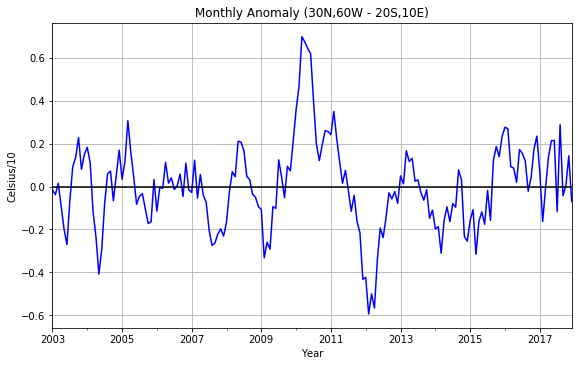

In [52]:
plota_coluna_do_dataframe(funceme_df, 'Monthly Anomaly (30N,60W - 20S,10E)',COLUNA_ANOMALIA_DO_MES)

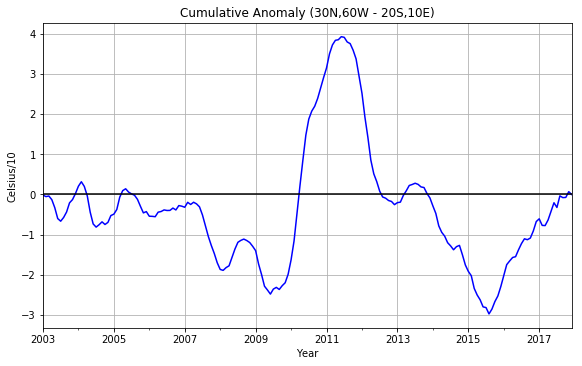

In [53]:
plota_coluna_do_dataframe(funceme_df, 'Cumulative Anomaly (30N,60W - 20S,10E)',COLUNA_ANOMALIA_ACUMULADA)

## Positive/Negative regions

In [54]:
'''ATN : 20N-0N / 50W-20W
ATS : 0N-18W / 30W-0W
DIPOLE = ATN - ATS
faz tambem ATL3
ATL3 : 3N-3S / 20W-0W
'''

colunas_atn_n = constroi_colunas_latitude_longitude(initial_n=19, end_n=0,
                                              initial_s=0, end_s=1,
                                              initial_w=49, end_w=20,
                                              initial_e=0, end_e=1)
colunas_atn_s = constroi_colunas_latitude_longitude(initial_n=0, end_n=0,
                                              initial_s=19, end_s=1,
                                              initial_w=29, end_w=0,
                                              initial_e=0, end_e=1)


In [55]:
ATN_df = pd.DataFrame(funceme_df, index=funceme_df.index, columns=colunas_atn_n)
ATS_df = pd.DataFrame(funceme_df, index=funceme_df.index, columns=colunas_atn_s)


In [56]:
#Drop NAN
ATN_df = ATN_df.dropna(axis=1, how='any')
ATS_df = ATS_df.dropna(axis=1, how='any')

In [57]:
#Média mensal
adiciona_media_mensal(ATN_df)
adiciona_media_mensal(ATS_df)

,29W-1S,29W-3S,29W-5S,29W-7S,29W-9S,29W-11S,29W-13S,29W-15S,29W-17S,27W-9S,27W-11S,27W-13S,27W-15S,27W-17S,25W-1S,25W-3S,25W-5S,23W-1S,23W-3S,23W-5S,23W-7S,23W-9S,23W-11S,23W-13S,23W-15S,23W-17S,21W-1S,19W-1S,19W-3S,19W-5S,19W-7S,19W-9S,19W-11S,19W-13S,19W-15S,19W-17S,17W-1S,17W-3S,17W-5S,17W-7S,17W-9S,17W-11S,17W-13S,17W-15S,17W-17S,15W-1S,15W-3S,13W-1S,13W-3S,13W-5S,13W-7S,13W-9S,13W-11S,13W-13S,13W-15S,13W-17S,11W-3S,11W-5S,11W-7S,11W-9S,11W-11S,11W-13S,11W-15S,11W-17S,9W-1S,9W-3S,9W-5S,7W-1S,7W-3S,7W-5S,7W-7S,7W-9S,7W-11S,7W-13S,7W-15S,7W-17S,5W-13S,5W-15S,5W-17S,3W-1S,3W-3S,3W-5S,3W-7S,3W-9S,3W-11S,1W-1S,1W-3S,1W-5S,1W-7S,1W-9S,1W-11S,1W-13S,1W-15S,1W-17S,media_mensal
2003-01-01,-0.2,-0.1,0.0,0.1,0.2,0.3,0.4,0.5,0.7,0.2,0.1,0.0,0.0,0.0,0.8,0.6,0.5,0.0,0.0,0.0,0.1,0.2,0.3,0.4,0.4,0.5,0.5,1.0,0.8,0.7,0.5,0.5,0.6,0.7,0.9,0.9,0.5,0.4,0.3,0.2,0.2,0.2,0.3,0.3,0.3,0.8,0.8,0.7,0.6,0.7,0.6,0.6,0.5,0.6,0.6,0.7,0.7,0.5,0.3,0.3,0.3,0.3,0.4,0.4,0.6,0.8,1.0,0.2,0.2,0.2,0.3,0.4,0.4,0.5,0.6,0.4,0.3,0.5,0.4,0.3,0.5,0.7,0.7,0.6,0.3,0.2,0.2,0.2,0.2,0.2,0.3,0.3,0.4,0.4,0.409574
2003-02-01,-0.3,-0.4,-0.5,-0.5,-0.5,-0.5,-0.5,-0.4,-0.3,0.2,0.3,0.2,0.2,0.1,-0.2,-0.1,0.0,-0.1,-0.2,-0.2,-0.2,-0.3,-0.2,-0.1,0.1,0.2,0.7,0.6,0.4,0.5,0.4,0.5,0.6,0.6,0.6,0.7,0.5,0.4,0.3,0.2,0.2,0.2,0.3,0.4,0.4,0.6,0.6,0.7,0.6,0.5,0.6,0.6,0.6,0.6,0.6,0.5,0.9,0.8,0.8,0.6,0.5,0.5,0.5,0.5,0.6,0.6,0.6,0.3,0.3,0.5,0.6,0.6,0.7,0.7,0.6,0.4,0.5,0.5,0.4,0.7,0.8,0.9,1.0,1.1,1.1,0.3,0.3,0.3,0.4,0.5,0.5,0.5,0.5,0.4,0.352128
2003-03-01,0.2,0.2,0.2,0.1,0.0,0.0,-0.1,0.0,0.1,2.0,1.8,1.3,0.9,0.5,0.4,0.6,0.6,0.0,0.0,0.1,0.2,0.1,0.1,0.0,0.0,0.1,1.1,0.9,0.8,0.8,0.8,0.8,0.8,0.7,0.8,0.9,0.2,0.1,0.0,0.0,0.1,0.2,0.2,0.2,0.3,1.0,1.1,0.9,0.9,1.0,0.9,0.8,0.8,0.5,0.4,0.5,0.4,0.3,0.2,0.2,0.3,0.4,0.4,0.4,0.7,0.8,0.9,0.2,0.2,0.4,0.6,0.8,0.8,0.8,0.6,0.5,0.4,0.5,0.4,0.6,0.7,0.6,0.7,0.8,0.7,0.0,0.0,0.1,0.3,0.4,0.6,0.7,0.7,0.6,0.495745
2003-04-01,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.3,0.2,0.1,0.0,-0.1,-0.2,-0.1,0.0,0.1,0.1,0.1,0.1,0.1,0.0,0.0,0.0,0.0,0.3,0.3,0.2,0.2,0.3,0.3,0.5,0.5,0.6,0.6,0.2,0.3,0.3,0.3,0.3,0.3,0.3,0.2,0.3,0.3,0.3,0.5,0.4,0.3,0.3,0.3,0.3,0.3,0.3,0.4,0.3,0.4,0.4,0.4,0.5,0.5,0.5,0.5,0.2,0.3,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.3,0.3,0.3,0.6,0.7,0.6,0.3,0.3,0.4,0.8,1.2,1.7,0.3,0.4,0.4,0.5,0.5,0.5,0.5,0.3,0.3,0.307447
2003-05-01,-0.2,0.0,0.2,0.3,0.4,0.4,0.3,0.3,0.2,0.0,0.0,0.1,0.1,0.2,0.4,0.5,0.5,0.1,0.2,0.2,0.4,0.4,0.4,0.3,0.2,0.2,0.9,0.5,0.5,0.4,0.3,0.1,0.2,0.2,0.4,0.5,0.4,0.3,0.4,0.4,0.5,0.4,0.3,0.2,0.1,0.9,1.0,0.4,0.4,0.5,0.2,0.1,-0.1,-0.1,0.0,0.0,0.6,0.6,0.6,0.5,0.5,0.4,0.3,0.2,0.5,0.8,1.1,0.0,0.2,0.5,0.5,0.4,0.4,0.2,0.0,-0.1,0.6,0.4,0.2,-0.1,0.2,0.6,0.9,1.1,1.4,-0.2,0.0,0.3,0.5,0.7,0.5,0.5,0.4,0.2,0.348936
2003-06-01,0.3,0.3,0.4,0.5,0.8,0.9,0.7,0.5,0.2,-0.1,-0.1,0.0,0.1,0.2,-0.2,-0.4,-0.4,0.1,0.1,0.2,0.4,0.4,0.6,0.6,0.5,0.3,0.2,0.0,-0.2,-0.5,-0.6,-0.5,-0.2,0.0,0.0,0.0,0.1,0.1,0.1,0.2,0.4,0.5,0.6,0.5,0.3,0.1,0.3,-0.1,-0.2,-0.3,-0.6,-0.7,-0.7,-0.4,0.0,0.1,0.0,0.1,0.3,0.3,0.5,0.5,0.5,0.3,0.2,0.2,0.2,-0.1,0.0,0.1,0.0,-0.2,-0.3,-0.4,-0.1,0.1,0.6,0.4,0.2,0.2,0.0,-0.1,-0.3,-0.3,-0.2,-0.2,0.0,0.1,0.3,0.3,0.1,0.1,0.0,0.1,0.094681
2003-07-01,0.3,0.3,0.5,0.6,0.6,0.7,0.5,0.3,0.0,1.0,0.9,0.8,0.7,0.7,-0.2,-0.1,0.1,0.3,0.3,0.4,0.5,0.7,0.7,0.6,0.5,0.3,0.5,-0.1,0.1,0.3,0.5,0.7,0.7,0.6,0.3,0.1,0.3,0.2,0.3,0.3,0.6,0.6,0.6,0.5,0.3,0.6,0.7,-0.4,-0.3,0.0,0.4,0.6,0.9,1.0,0.9,0.7,0.2,0.2,0.3,0.3,0.4,0.4,0.4,0.3,0.7,0.8,1.0,-0.3,-0.5,-0.5,-0.4,-0.1,0.3,0.5,0.6,0.6,0.3,0.2,0.2,0.5,0.6,0.7,0.8,1.0,1.1,0.0,0.0,-0.2,-0.3,-0.1,0.0,0.1,0.2,0.2,0.372340
2003-08-01,1.2,1.1,1.1,1.1,1.0,1.0,0.9,0.6,0.4,0.8,1.0,1.0,1.1,1.0,0.1,0.0,0.1,0.7,0.7,0.8,0.9,0.8,0.9,0.7,0.5,0.2,0.9,0.3,0.5,0.5,0.5,0.6,0.7,0.9,1.1,1.2,0.4,0.3,0.4,0.4,0.5,0.6,0.6,0.4,0.3,1.3,1.2,0.5,0.7,0.9,1.0,1.0,1.0,1.2,1.3,1.4,0.2,0.2,0.1,0.2,0.3,0.4,0.4,0.3,1.3,1.4,1.5,0.5,0.6,0.7,0.9,1.0,1.0,0.9,0.9,1.0,0.3,0.3,0.2,0.9,0.9,0.9,1.1,1.3,1.6,0.1,0.4,0.4,0.5,0.5,0.6,0.6,0.6,0.5,0.721277
2003-09-01,0.7,0.6,0.6,0.6,0.8,0.9,0.9,0.9,0.7,1.1,1.1,1.2,1.2,1.3,0.4,0.5,0.7,0

In [58]:
#Climatologia
calcula_climatologia_para_dataframe(ATN_df)
calcula_climatologia_para_dataframe(ATS_df)

{1: 0.5093617021276596,
 2: 0.43553191489361714,
 3: 0.5163120567375886,
 4: 0.46326241134751783,
 5: 0.5213475177304965,
 6: 0.49560283687943263,
 7: 0.5191489361702127,
 8: 0.6221276595744681,
 9: 0.5498581560283688,
 10: 0.6604964539007091,
 11: 0.5621985815602837,
 12: 0.5959574468085107}

In [59]:
#Anomalia
ATN_df = adiciona_anomalia(ATN_df)
ATS_df = adiciona_anomalia(ATS_df)

In [60]:
#AnomaliaCumulativa
ATN_df = adiciona_anomalia_acumulada(ATN_df)
ATs_df = adiciona_anomalia_acumulada(ATS_df)


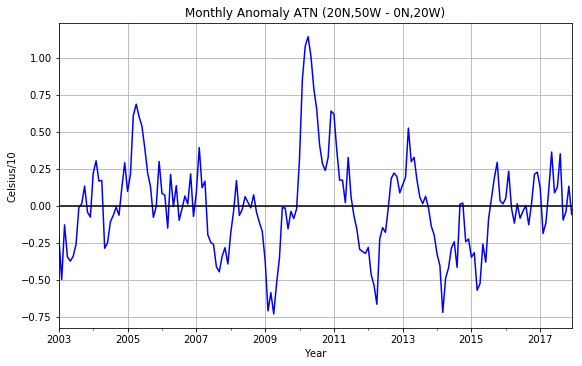

In [61]:
plota_coluna_do_dataframe(ATN_df, 'Monthly Anomaly ATN (20N,50W - 0N,20W)',COLUNA_ANOMALIA_DO_MES)

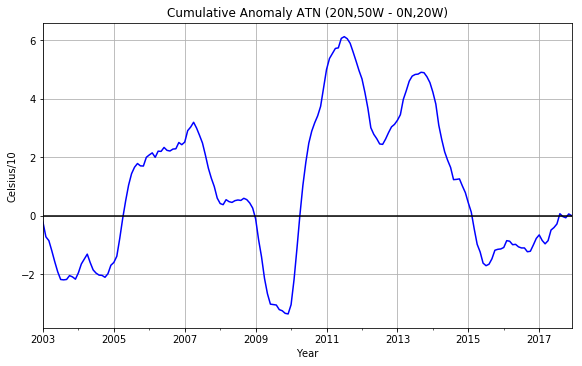

In [62]:
plota_coluna_do_dataframe(ATN_df, 'Cumulative Anomaly ATN (20N,50W - 0N,20W)',COLUNA_ANOMALIA_ACUMULADA)

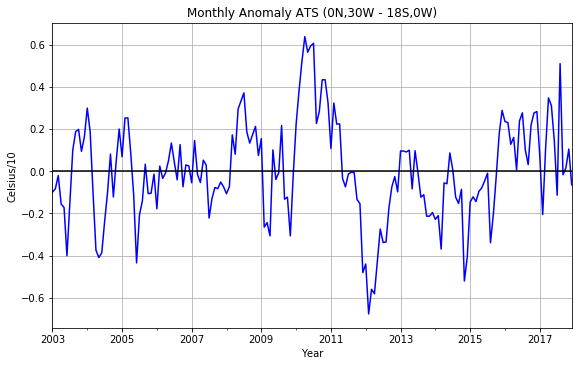

In [63]:
plota_coluna_do_dataframe(ATS_df, 'Monthly Anomaly ATS (0N,30W - 18S,0W)',COLUNA_ANOMALIA_DO_MES)

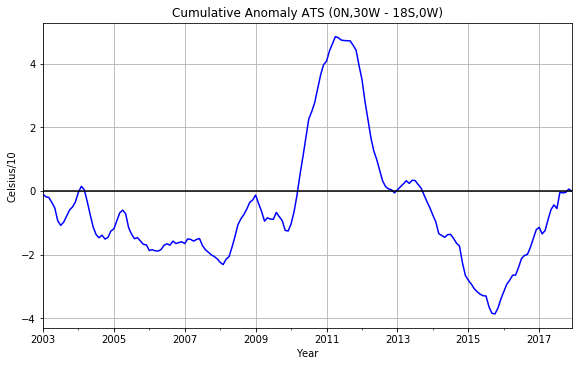

In [64]:
plota_coluna_do_dataframe(ATS_df, 'Cumulative Anomaly ATS (0N,30W - 18S,0W)',COLUNA_ANOMALIA_ACUMULADA)

## Dipole

In [65]:
dipolo_df = pd.DataFrame(index=funceme_df.index, columns=[COLUNA_ANOMALIA_ACUMULADA])

In [66]:
dipolo_df[COLUNA_ANOMALIA_ACUMULADA] = ATN_df[COLUNA_ANOMALIA_ACUMULADA] - ATS_df[COLUNA_ANOMALIA_ACUMULADA]

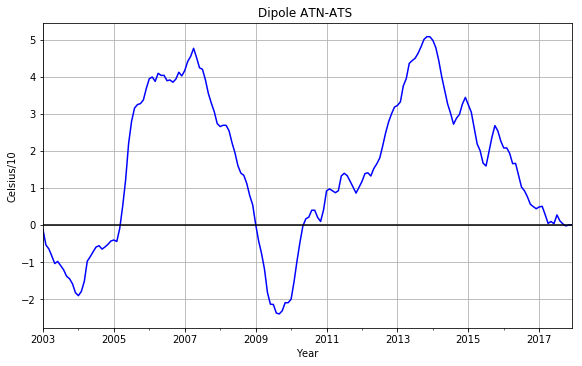

In [67]:
plota_coluna_do_dataframe(dipolo_df, 'Dipole ATN-ATS ',COLUNA_ANOMALIA_ACUMULADA)

# Last area

In [68]:
# ATL3 : 3N-3S / 20W-0W

colunas_atl3 = constroi_colunas_latitude_longitude(initial_n=3, end_n=0,
                                              initial_s=3, end_s=0,
                                              initial_w=19, end_w=0,
                                              initial_e=0, end_e=0)
ATL3_df=pd.DataFrame(funceme_df, index=funceme_df.index, columns=colunas_atl3)
ATL3_df = ATL3_df.dropna(axis=1, how='any')
adiciona_media_mensal(ATL3_df)
calcula_climatologia_para_dataframe(ATL3_df)
ATL3_df = adiciona_anomalia(ATL3_df)
ATL3_df = adiciona_anomalia_acumulada(ATL3_df)


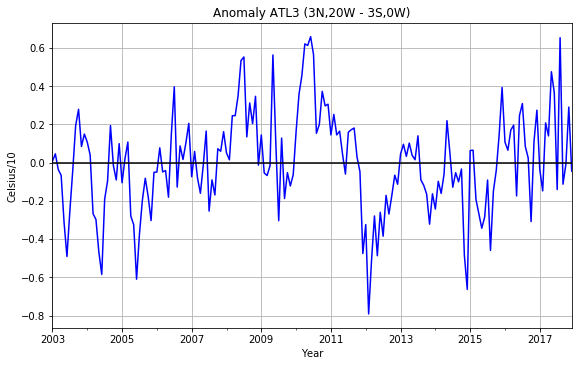

In [69]:
plota_coluna_do_dataframe(ATL3_df, 'Anomaly ATL3 (3N,20W - 3S,0W)',COLUNA_ANOMALIA_DO_MES)

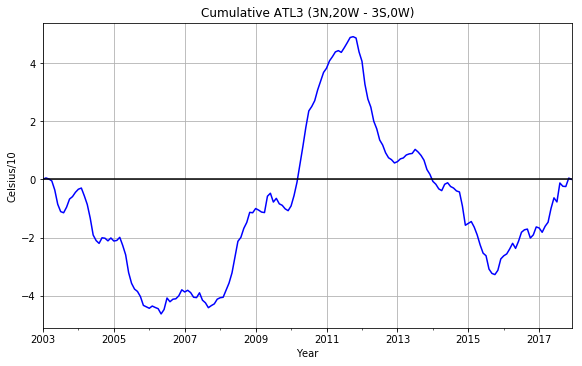

In [70]:
plota_coluna_do_dataframe(ATL3_df, 'Cumulative ATL3 (3N,20W - 3S,0W)',COLUNA_ANOMALIA_ACUMULADA)

# Same analysis fom jan/2003 to dez/2017

## TN (27N,59W - 5N,15E)

In [71]:
# Construir colunas
colunas_tn = constroi_colunas_latitude_longitude(initial_n=27, end_n=3,
                                                initial_s=0, end_s=0,
                                                initial_w=59, end_w=0,
                                                initial_e=16, end_e=1)

#Montar dataframe
tn_df=pd.DataFrame(geral_df, index=geral_df.index, columns=colunas_tn)

#Filtrar por data
tn_df = tn_df.loc['2003-01-01':'2017-12-01']

#Remover NAN
tn_df = tn_df.replace(9999.8, np.nan)
tn_df = tn_df.dropna(axis=1, how='any')

#Calcula media mensal
adiciona_media_mensal(tn_df)

#Calcular climatologia
# calcula_climatologia_para_dataframe(tn_df)

#Calcular anomalia mensal
tn_df = adiciona_anomalia(tn_df)

#Montar anomalia acumulada
tn_df = adiciona_anomalia_acumulada(tn_df)


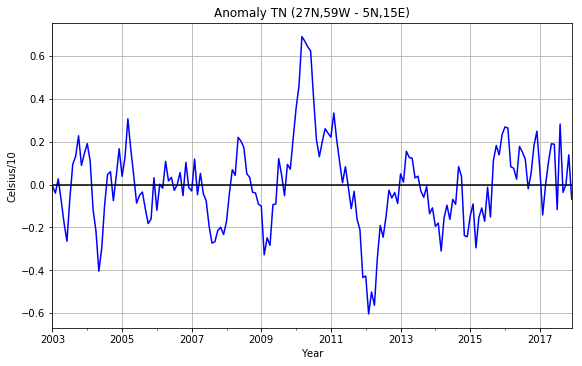

In [72]:
plota_coluna_do_dataframe(tn_df, 'Anomaly TN (27N,59W - 5N,15E)',COLUNA_ANOMALIA_DO_MES)

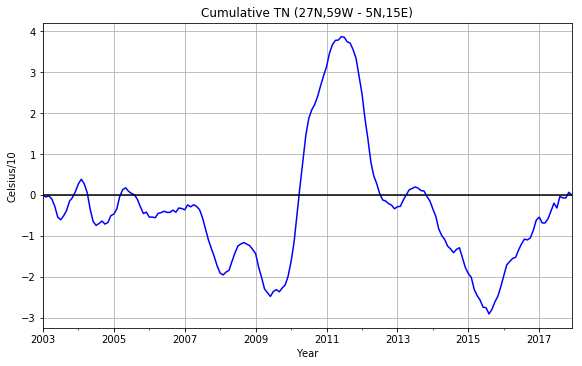

In [73]:
plota_coluna_do_dataframe(tn_df, 'Cumulative TN (27N,59W - 5N,15E)',COLUNA_ANOMALIA_ACUMULADA)

## TS (5N,59W - 20S,15E)

In [74]:
# Construir colunas
colunas_ts = constroi_colunas_latitude_longitude(initial_n=5, end_n=0,
                                                initial_s=21, end_s=1,
                                                initial_w=59, end_w=0,
                                                initial_e=16, end_e=1)

#Montar dataframe
ts_df=pd.DataFrame(geral_df, index=geral_df.index, columns=colunas_ts)

#Filtrar por data
ts_df = ts_df.loc['2003-01-01':'2017-12-01']

#Remover NAN
ts_df = ts_df.replace(9999.8, np.nan)
ts_df = ts_df.dropna(axis=1, how='any')

#Calcula media mensal
adiciona_media_mensal(ts_df)

#Calcular climatologia
# calcula_climatologia_para_dataframe(ts_df)

#Calcular anomalia mensal
ts_df = adiciona_anomalia(ts_df)

#Montar anomalia acumulada
ts_df = adiciona_anomalia_acumulada(ts_df)



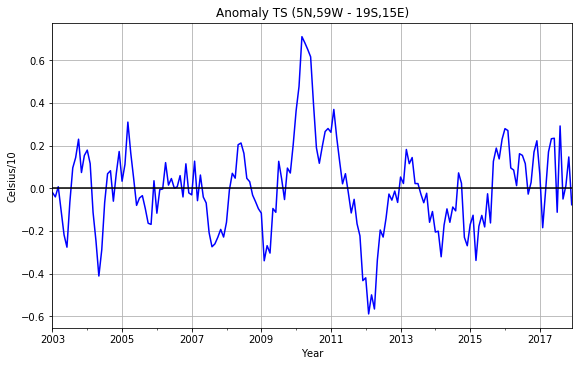

In [75]:
plota_coluna_do_dataframe(ts_df, 'Anomaly TS (5N,59W - 19S,15E)',COLUNA_ANOMALIA_DO_MES)

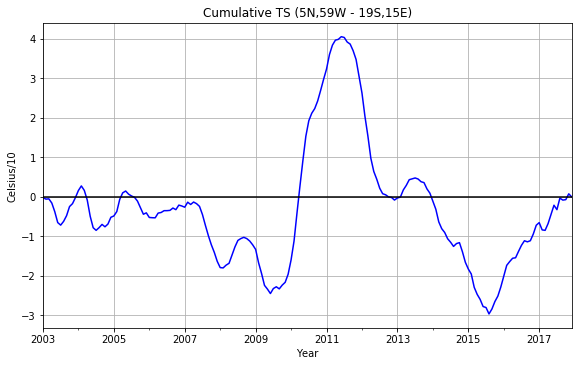

In [76]:
plota_coluna_do_dataframe(ts_df, 'Cumulative TS (5N,59W - 19S,15E)',COLUNA_ANOMALIA_ACUMULADA)

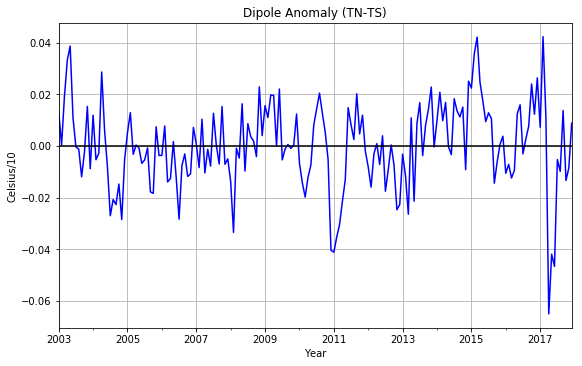

In [77]:
dipolo_df = pd.DataFrame(index=ts_df.index, columns=[COLUNA_ANOMALIA_DO_MES])
dipolo_df[COLUNA_ANOMALIA_DO_MES] = tn_df[COLUNA_ANOMALIA_DO_MES] - ts_df[COLUNA_ANOMALIA_DO_MES]
plota_coluna_do_dataframe(dipolo_df, 'Dipole Anomaly (TN-TS)',COLUNA_ANOMALIA_DO_MES)

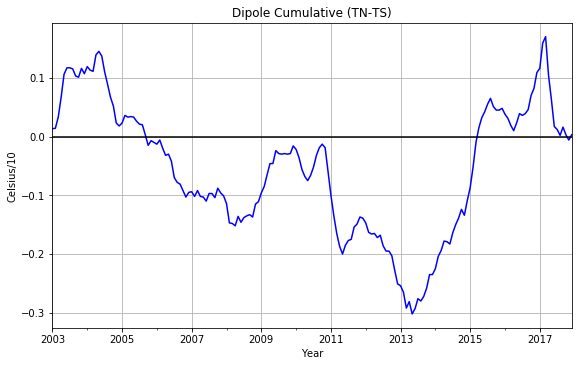

In [78]:
ipolo_df = pd.DataFrame(index=ts_df.index, columns=[COLUNA_ANOMALIA_ACUMULADA])
dipolo_df[COLUNA_ANOMALIA_ACUMULADA] = tn_df[COLUNA_ANOMALIA_ACUMULADA] - ts_df[COLUNA_ANOMALIA_ACUMULADA]
plota_coluna_do_dataframe(dipolo_df, 'Dipole Cumulative (TN-TS)',COLUNA_ANOMALIA_ACUMULADA)